In [30]:
!pip3 install pyro-ppl 

In [2]:
!pip install extinction

     |████████████████████████████████| 95 kB 6.2 MB/s             


In [3]:
!pip install corner

In [31]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors


import corner
import time as measure_time

import pyro

import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO,Predictive
from pyro.optim import Adam

from scipy.interpolate import interp1d
import h5py
import extinction

from astropy.cosmology import FlatLambdaCDM

from spline_hsiao_fns import *

##Get constants from files

In [2]:
W0 = np.loadtxt("../parameter files/W0.txt")
W1 = np.loadtxt("../parameter files/W1.txt")
time_knots = np.loadtxt("../parameter files/tau_knots.txt")
wavelength_knots = np.loadtxt("../parameter files/l_knots.txt")
L_sigma_epsilon = np.loadtxt("../parameter files/L_Sigma_epsilon.txt")
M0, sigma0, rv, tauA = np.loadtxt("../parameter files/M0_sigma0_RV_tauA.txt")

In [3]:
g_wavelengths, _, g_norm_throughput = np.loadtxt("../parameter files/g_PS1.txt", skiprows = 2, unpack = True)
r_wavelengths, _, r_norm_throughput = np.loadtxt("../parameter files/r_PS1.txt", skiprows = 2, unpack = True)
i_wavelengths, _, i_norm_throughput = np.loadtxt("../parameter files/i_PS1.txt", skiprows = 2, unpack = True)
z_wavelengths, _, z_norm_throughput = np.loadtxt("../parameter files/z_PS1.txt", skiprows = 2, unpack = True)

In [4]:
filename = "../parameter files/ASASSN-16cs.dat"

df = pd.read_csv(filename, sep=" ", header = 0, index_col = False, names = ['MJD', "FLT", 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'])
df = df.dropna()
df.head()

,MJD,FLT,FLUXCAL,FLUXCALERR,MAG,MAGERR
0,57459.23554,g,37214.832,567.712,16.073,0.017
1,57467.23967,g,41744.556,650.066,15.949,0.017
2,57475.26347,g,28919.307,447.921,16.347,0.017
3,57483.24414,g,16594.694,286.561,16.950,0.019
4,57495.24593,g,5925.251,190.618,18.068,0.035


In [5]:
tmax = 57464.23 if filename=="../parameter files/ASASSN-16cs.dat" else 57442.92
z_helio = 0.01802 if filename=="../parameter files/ASASSN-16cs.dat" else 0.06741

g_time = (df.MJD[df.FLT=='g'] - tmax) / (1 + z_helio)
r_time = (df.MJD[df.FLT=='r'] - tmax) / (1 + z_helio)
i_time = (df.MJD[df.FLT=='i'] - tmax) / (1 + z_helio)
z_time = (df.MJD[df.FLT=='z'] - tmax) / (1 + z_helio)

g_mag = df.MAG[df.FLT=='g']
r_mag = df.MAG[df.FLT=='r']
i_mag = df.MAG[df.FLT=='i']
z_mag = df.MAG[df.FLT=='z']

g_magerr = df.MAGERR[df.FLT=='g']
r_magerr = df.MAGERR[df.FLT=='r']
i_magerr = df.MAGERR[df.FLT=='i'][:-1]
z_magerr = df.MAGERR[df.FLT=='z']

g_flux = df.FLUXCAL[df.FLT=='g']
r_flux = df.FLUXCAL[df.FLT=='r']
i_flux = df.FLUXCAL[df.FLT=='i']
z_flux = df.FLUXCAL[df.FLT=='z']

g_fluxerr = df.FLUXCALERR[df.FLT=='g']
r_fluxerr = df.FLUXCALERR[df.FLT=='r']
i_fluxerr = df.FLUXCALERR[df.FLT=='i'][:-1]
z_fluxerr = df.FLUXCALERR[df.FLT=='z']

i_mag = i_mag[:-1]
i_time = i_time[:-1] ## remove last point which is outside the (-10, 40) time range

i_flux = i_flux[:-1]

In [6]:
i_flux

12    26961.986
13    26856.407
14    16242.429
15    14363.332
16    17213.704
17    11524.010
Name: FLUXCAL, dtype: float64

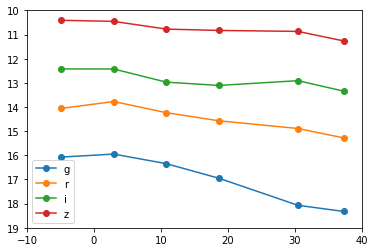

In [7]:
plt.plot(g_time, g_mag, label='g', marker='o')
plt.plot(r_time, r_mag-2, label = 'r', marker='o')
plt.plot(i_time, i_mag-4,label = 'i', marker='o')
plt.plot(z_time, z_mag-6, label = 'z', marker='o')
plt.legend()
plt.ylim(19,10)
plt.xlim(-10, 40)
plt.show() ## replicating Stephen's figure (Figure 11 in Foundation DR1 with BayeSN)

In [8]:
# cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
# z = pyro.sample("z", dist.Uniform(0.015, 0.08)).numpy()
# mu_s = cosmo.distmod(z).value

z = 0.018
mu_s = 31.

z_helio = 0.01802 ## for ASASSN
EBV_MW = 0.1145 ## for ASASSN

ZPT = 27.5
M0 = -19.5
gamma = np.log(10) / 2.5

EBV_MW = 0.1
Av_obs = EBV_MW * 3.1

In [9]:
hsiao_phase, hsiao_wave, hsiao_flux = read_model_grid()

Things we can pre-calculate
---



In [10]:
def get_lambda_int_for_band(band_wavelengths, z = z):
  source_wavelengths = band_wavelengths / (1 + z)
  return np.linspace(np.min(source_wavelengths), np.max(source_wavelengths), 150)

In [11]:
# times_to_interpolate = np.linspace(-10, 40)
times_to_interpolate = i_time.values
wavelengths_to_interpolate = get_lambda_int_for_band(i_wavelengths)

In [12]:
Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))
Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))

In [13]:
xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T
xis_matrix.shape

(150, 6)

In [14]:
## interpolate Hsiao coefficient at desired time and wavelength points
S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
for i, wavelength in enumerate(wavelengths_to_interpolate):
  for j, time in enumerate(times_to_interpolate):
    S0[i][j] = interpolate_hsiao(time, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

In [15]:
throughput_interpolator = interp1d(i_wavelengths, i_norm_throughput)
b = throughput_interpolator(wavelengths_to_interpolate * (1 + z))

xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)
h.shape

(150,)

Now let's actually make the model
---

In [16]:
eps_cov = torch.as_tensor(np.matmul(L_sigma_epsilon, L_sigma_epsilon.T), dtype = torch.float)

In [17]:
def get_flux_from_params(epsilon_interior, theta, mu_s, dMs, Av, W0 = W0, W1 = W1, xis_matrix = xis_matrix, S0 = S0, h = h, Jl = Jl, Jt = Jt):

  epsilon = np.zeros_like(W0)   ## populate epsilon matrix
  epsilon[1:-1] = epsilon_interior.numpy().reshape((9,6), order = 'F')

  W = W0 + theta.numpy()*W1 + epsilon

  JlWJt = np.matmul(Jl, np.matmul(W, Jt.T))

  Stilde = S0 * np.exp(-gamma * (JlWJt + Av.numpy() * xis_matrix))

  f = 10**(0.4 * (ZPT - mu_s.numpy() - M0 - dMs.numpy())) * np.matmul(h,Stilde)

  return f

In [18]:
tauA

0.252

In [19]:
pyro.sample("Av", dist.Exponential(tauA))

tensor(2.0554)

In [20]:
# def model_vi():
#   epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))
#   theta = pyro.sample("theta", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
#   mu_s = pyro.sample("mu_s", dist.Normal(34.5, 1.)) ## fix this later


#   # dMs = pyro.sample("Ms", dist.Normal(torch.tensor(0.), torch.tensor(sigma0)))
#   dMs = torch.tensor(0.)
#   # Av = pyro.sample("Av", dist.Exponential(tauA))
#   Av = pyro.sample("Av", dist.Normal(0.27, 1.))

#   epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
#   epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)

#   W = torch.as_tensor(W0) + theta*torch.as_tensor(W1) + epsilon

#   JlWJt = torch.matmul(torch.as_tensor(Jl), torch.matmul(W, torch.as_tensor(Jt.T)))

#   Stilde = torch.as_tensor(S0) * torch.exp(-gamma * (JlWJt + Av * torch.as_tensor(xis_matrix)))

#   f = 10**(0.4 * ZPT - mu_s - M0 - dMs) * torch.matmul(torch.as_tensor(h), torch.as_tensor(Stilde))

#   with pyro.plate("observations", len(i_flux.values)):
#     pyro.sample("flux", dist.Normal(f, 200. * torch.ones(6)).independent(1), obs = torch.as_tensor(i_flux.values))

In [21]:
Av_obs

0.31000000000000005

In [22]:
# times_to_interpolate = times
Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))

wavelengths_dict = {'g':g_wavelengths, 'r':r_wavelengths, 'i':i_wavelengths, 'z':z_wavelengths}
norm_throughput_dict = {'g':g_norm_throughput, 'r':r_norm_throughput, 'i':i_norm_throughput, 'z':z_norm_throughput}

bands = ['g', 'r', 'i', 'z']

band_Jl = {}
band_xis_matrix = {}
band_S0 = {}
band_h = {}

for band in bands:
  band_wavelengths = wavelengths_dict[band]
  band_norm_throughput = norm_throughput_dict[band]

  wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths)
  
  Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
  band_Jl[band] = Jl
  xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
  xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T
  band_xis_matrix[band] = xis_matrix

  S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
  for i, wavelength in enumerate(wavelengths_to_interpolate):
    for j, time_point in enumerate(times_to_interpolate):
      S0[i][j] = interpolate_hsiao(time_point, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

  band_S0[band] = S0

  throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
  b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z)) + [band_wavelengths[-1]])

  xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
  dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
  h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)

  band_h[band] = h

#   band_flux = get_flux_from_params(torch.as_tensor(true_epsilon_interior), torch.as_tensor(true_theta), 
#                               torch.as_tensor(true_mu_s), torch.as_tensor(dMs), torch.as_tensor(true_Av),
#                               xis_matrix = xis_matrix, S0 = S0, h = h, Jt = Jt, Jl = Jl)
  
#   all_band_fluxes.append(band_flux)

# all_band_fluxes = np.array(all_band_fluxes)

In [23]:
def model_vi(obs):
  # epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))

  nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov))))
  # nu = torch.zeros(54)
  epsilon_interior = torch.matmul(torch.as_tensor(L_sigma_epsilon, dtype = torch.float), nu)
  # print(epsilon_interior)

  # theta = pyro.sample("theta", dist.Uniform(low=-1.49, high=2.77))
  theta = pyro.sample("theta", dist.Normal(0., 1.0))
  # theta = torch.as_tensor(0.03430605)

  # theta = torch.as_tensor(-0.9835187)
  cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
  mu_s = pyro.sample("mu_s", dist.Normal(cosmo.distmod(z_helio).value, 10.)) ## fix this later
  # mu_s = torch.as_tensor(37.248927127193724)

  # dMs = pyro.sample("Ms", dist.Normal(torch.tensor(0.), torch.tensor(sigma0)))
  dMs = torch.tensor(0.)
  Av = pyro.sample("Av", dist.Exponential(1 / 0.252))
  # Av = torch.tensor(7.2387767)
  # Av = pyro.sample("Av", dist.Normal(0.27, 1.))

  epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)

  W = torch.as_tensor(W0) + theta*torch.as_tensor(W1) + epsilon

  generated_fluxes = []

  for band in bands:
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]

    JlWJt = torch.matmul(torch.as_tensor(Jl), torch.matmul(W, torch.as_tensor(Jt.T)))

    Stilde = torch.as_tensor(S0) * torch.exp(-gamma * (JlWJt + Av * torch.as_tensor(xis_matrix)))

    f = 10**(0.4 * (torch.as_tensor(ZPT) - mu_s - torch.as_tensor(M0) - dMs)) * torch.matmul(torch.as_tensor(h), torch.as_tensor(Stilde))
    generated_fluxes.append(f)

  generated_fluxes = torch.stack(generated_fluxes)
  # print(generated_fluxes)

  with pyro.plate("bands"):
    with pyro.plate("observations"):
      pyro.sample("flux", dist.Normal(generated_fluxes, 0.02 * generated_fluxes), obs = obs)

In [24]:
observed_fluxes = torch.stack((torch.as_tensor(g_flux.values), torch.as_tensor(r_flux.values), torch.as_tensor(i_flux.values), torch.as_tensor(z_flux.values)))

In [25]:
observed_fluxes

tensor([[37214.8320, 41744.5560, 28919.3070, 16594.6940,  5925.2510,  4677.9380],
        [37692.5560, 49035.7990, 32039.7580, 23530.7970, 17534.8310, 12236.5950],
        [26961.9860, 26856.4070, 16242.4290, 14363.3320, 17213.7040, 11524.0100],
        [27262.1680, 26132.5180, 19475.8830, 18520.2020, 17852.0100, 12386.0600]],
       dtype=torch.float64)

In [26]:
other_tensor = torch.as_tensor(np.array([[52404.7879, 58130.4852, 46895.5337, 29594.8725, 17534.0982, 11053.1069],
        [48598.4592, 57606.4501, 51917.4832, 38853.5554, 30378.8843, 24328.2872],
        [40029.6385, 34592.7530, 29652.9017, 23438.5865, 22959.2071, 21189.7540],
        [30952.7222, 34969.4993, 35130.8207, 31905.8129, 28952.3929, 26269.5857]]))

In [27]:
model_vi(obs = observed_fluxes)

In [32]:
pyro.render_model(model_vi, model_args = (observed_fluxes,), render_distributions=True, render_params = True)

TypeError: render_model() got an unexpected keyword argument 'render_params'

In [33]:
autoguide_vi = pyro.infer.autoguide.AutoMultivariateNormal(model_vi, init_loc_fn = pyro.infer.autoguide.initialization.init_to_median(), init_scale = 0.8)

In [34]:
pyro.get_param_store().clear()
adam = pyro.optim.Adam({"lr": 0.001, "betas": (0.90, 0.999)}, {"clip_norm": 10.0})
# adam = pyro.optim.SGD({"lr": 0.1})


svi = SVI(model_vi, autoguide_vi, adam, loss=Trace_ELBO().differentiable_loss)
# svi = SVI(model_vi, custom_guide, adam, loss=Trace_ELBO().differentiable_loss)

for i in range(10):
  svi.step(observed_fluxes)

In [35]:
def train(model, guide, lr=0.01, n_steps=5000, verbose = True):
    pyro.get_param_store().clear()
    adam_params = {"lr": lr, "betas": (0.95, 0.999)}
    # adam = pyro.optim.Adam({"lr": 0.05}, {"clip_norm": 10.0})
    adam = pyro.optim.ClippedAdam(adam_params)
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    losses = []
    losses_every_500 = []

    for step in range(n_steps):
        loss = svi.step(observed_fluxes)
        losses.append(loss)
        if verbose and step % 500 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))
            losses_every_500.append(loss)
            ## if it hasn't decreased in 3 steps, end fitting
            # if step > 2000:
            #  if losses_every_500[-1] >= losses_every_500[-2] and losses_every_500[-2] >= losses_every_500[-3]:
            #   break
    return losses

In [36]:
start_time = measure_time.time()
losses = train(model_vi, autoguide_vi, lr = 0.005, n_steps = 20000)
end_time = measure_time.time()
print("Time:", end_time - start_time, "seconds")

[iter 0]  loss: 29416.6242
[iter 500]  loss: 7962.8939
[iter 1000]  loss: 3640.8935
[iter 1500]  loss: 721.6332
[iter 2000]  loss: 522.9279
[iter 2500]  loss: 1196.4763
[iter 3000]  loss: 323.2307
[iter 3500]  loss: 328.7253
[iter 4000]  loss: 270.8923
[iter 4500]  loss: 246.7455
[iter 5000]  loss: 224.3594
[iter 5500]  loss: 224.4021
[iter 6000]  loss: 220.1658
[iter 6500]  loss: 216.2565
[iter 7000]  loss: 215.6469
[iter 7500]  loss: 214.1728
[iter 8000]  loss: 210.5454
[iter 8500]  loss: 211.7627
[iter 9000]  loss: 215.4559
[iter 9500]  loss: 213.1411
[iter 10000]  loss: 210.7845
[iter 10500]  loss: 209.9382
[iter 11000]  loss: 209.0015
[iter 11500]  loss: 215.7340
[iter 12000]  loss: 214.5571
[iter 12500]  loss: 221.3856
[iter 13000]  loss: 211.0769
[iter 13500]  loss: 213.1132
[iter 14000]  loss: 214.3243
[iter 14500]  loss: 211.2350
[iter 15000]  loss: 218.9985
[iter 15500]  loss: 208.0030
[iter 16000]  loss: 210.0577
[iter 16500]  loss: 209.9038
[iter 17000]  loss: 216.4044
[ite

In [ ]:
plt.plot(losses)

In [ ]:
autoguide_vi.median()['theta']

In [ ]:
autoguide_vi.median()['Av']

In [ ]:
autoguide_vi.median()['mu_s']

In [ ]:
autoguide_vi.median()['nu']

In [ ]:
autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi)
start_time = measure_time.time()
losses = train(model_vi, autoguide_laplace, n_steps = 10000)
end_time = measure_time.time()
print("Time:", end_time - start_time, "seconds")

In [ ]:
new_laplace_approx_guide = autoguide_laplace.laplace_approximation(observed_fluxes)
losses = train(model_vi, new_laplace_approx_guide, n_steps = 10000)

In [ ]:
posterior_samples = Predictive(model_vi, guide = autoguide_vi, num_samples = 100)(None,)
posterior_samples['Av'][:,0,0].shape

In [ ]:
def calculate_all_fluxes_from_params(nu, theta, mu_s, dMs, Av):
  times_to_interpolate = np.linspace(-10, 40)
  Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))

  epsilon_interior = np.matmul(L_sigma_epsilon, nu.numpy().T)

  epsilon = np.zeros_like(W0)   ## populate epsilon matrix
  epsilon[1:-1] = epsilon_interior.reshape((9,6), order = 'F')

  W = W0 + theta.numpy()*W1 + epsilon

  generated_fluxes_from_params = []

  for band in bands:
    band_wavelengths = wavelengths_dict[band]
    band_norm_throughput = norm_throughput_dict[band]

    Jl = band_Jl[band]
    # xis_matrix = band_xis_matrix[band]
    # h = band_h[band]

    wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths)
    
    # Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
    xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
    xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T

    S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
    for i, wavelength in enumerate(wavelengths_to_interpolate):
      for j, time in enumerate(times_to_interpolate):
        S0[i][j] = interpolate_hsiao(time, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

    throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
    b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z)) + [band_wavelengths[-1]])

    xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
    dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
    h = (1 + z) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)

    band_flux = get_flux_from_params(torch.as_tensor(epsilon_interior), torch.as_tensor(theta), 
                                torch.as_tensor(mu_s), torch.as_tensor(dMs), torch.as_tensor(Av),
                                xis_matrix = xis_matrix, S0 = S0, h = h, Jt = Jt, Jl = Jl)
    
    generated_fluxes_from_params.append(band_flux)
  
  return np.array(generated_fluxes_from_params)

In [ ]:
posterior_smooth_curves = []
for nu, theta, mu_s, Av in zip(posterior_samples['nu'][:,0,0], posterior_samples['theta'][:,0,0], posterior_samples['mu_s'][:,0,0], posterior_samples['Av'][:,0,0]):
  # print(nu, theta, mu_s, Av)
  posterior_smooth_curves.append(calculate_all_fluxes_from_params(nu, theta, mu_s, torch.as_tensor(0.), Av))

In [ ]:
posterior_smooth_curves = np.array(posterior_smooth_curves)
median_posterior_fit = np.median(posterior_smooth_curves, axis = 0)
upper_posterior_fit = np.percentile(posterior_smooth_curves, 50 + 34.1, axis = 0)
lower_posterior_fit = np.percentile(posterior_smooth_curves, 50 - 34.1, axis = 0)

In [ ]:
colors  = ['g', 'r', 'c', 'k']
# offset = np.array([0, 1000,2000,3000]) * 30
offset = np.zeros(4)
for i, band_flux in enumerate(median_posterior_fit):
    plt.plot(np.linspace(-10, 40), band_flux + offset[i], color = colors[i])
    plt.fill_between(np.linspace(-10, 40), upper_posterior_fit[i]+ offset[i], lower_posterior_fit[i]+ offset[i], color = colors[i], alpha = 0.2)
for i, band_flux in enumerate(observed_fluxes.numpy()):
  plt.plot(times_to_interpolate, band_flux + offset[i], 'o',color = colors[i], label = bands[i])
plt.legend()
plt.title("Posterior samples from VI")

In [ ]:
num_corner_samples = 1000
vi_corner_samples = Predictive(model_vi, guide = autoguide_vi, num_samples = num_corner_samples)(None,)

In [ ]:
vi_trained_laplace_samples = Predictive(model_vi, guide = new_laplace_approx_guide, num_samples = num_corner_samples)(None,)

In [ ]:
laplace_samples = Predictive(model_vi, guide = autoguide_laplace.laplace_approximation(observed_fluxes), num_samples = num_corner_samples)(None,)

In [ ]:
other_fit = np.load("ASASSN-16cs_chains_210610_135216.npy", allow_pickle = True).item()

In [ ]:
other_fit.keys()

In [ ]:
len(other_fit['mu'])

In [ ]:
figure = corner.corner(np.vstack((vi_corner_samples['mu_s'][:,0,0].numpy(),vi_corner_samples['theta'][:,0,0].numpy(), 
                                  vi_corner_samples['Av'][:,0,0].numpy())).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"])
corner.corner(np.vstack((vi_trained_laplace_samples['mu_s'][:,0,0].numpy(),vi_trained_laplace_samples['theta'][:,0,0].numpy(), 
                                  vi_trained_laplace_samples['Av'][:,0,0].numpy())).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'c')
# corner.corner(np.vstack((laplace_samples['mu_s'][:,0,0].numpy(),laplace_samples['theta'][:,0,0].numpy(), 
#                                   laplace_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'b')
corner.corner(np.vstack((other_fit['mu'] + other_fit['delM'],other_fit['theta'], other_fit['AV'])).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'r')
colors = ['k','c', 'r']

labels = ['VI', 'VI init from Laplace approx', 'MCMC']

plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=labels[i])
        for i in range(len(labels))
    ],
    fontsize=16, frameon=False,
    bbox_to_anchor=(1, 3), loc="upper right"
)
figure.suptitle("Parameter distributions for ASASSN-16CS dataset", fontsize = 20)
plt.show()

In [ ]:
def model_mcmc(obs = observed_fluxes):
  # epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))

  nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov))))
  # nu = torch.zeros(54)
  nu = torch.as_tensor(nu, dtype = torch.double)
  # print(nu.type())
  epsilon_interior = torch.matmul(torch.as_tensor(L_sigma_epsilon, dtype = torch.double), nu)
  # print(epsilon_interior)

  # theta = pyro.sample("theta", dist.Uniform(low=-1.49, high=2.77))
  theta = pyro.sample("theta", dist.Normal(0., 1.0))
  # theta = torch.as_tensor(0.03430605)

  # theta = torch.as_tensor(-0.9835187)
  # mu_s = pyro.sample("mu_s", dist.Normal(34.5, 1.)) ## fix this later
  cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
  mu_s = pyro.sample("mu_s", dist.Normal(cosmo.distmod(z_helio).value, 10.)) ## fix this later
  # mu_s = pyro.sample("mu_s", dist.Uniform(0., 999999999)) ## fix this later

  # mu_s = torch.as_tensor(37.248927127193724)

  # dMs = pyro.sample("Ms", dist.Normal(torch.tensor(0.), torch.tensor(sigma0)))
  dMs = torch.tensor(0.)
  Av = pyro.sample("Av", dist.Exponential(1 / 0.252))
  # Av = torch.tensor(7.2387767)
  # Av = pyro.sample("Av", dist.Normal(0.27, 1.))

  epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)

  W = torch.as_tensor(W0) + theta*torch.as_tensor(W1) + epsilon

  generated_fluxes = []

  for band in bands:
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]

    JlWJt = torch.matmul(torch.as_tensor(Jl), torch.matmul(W, torch.as_tensor(Jt.T)))

    Stilde = torch.as_tensor(S0) * torch.exp(-gamma * (JlWJt + Av * torch.as_tensor(xis_matrix)))

    f = 10**(0.4 * (torch.as_tensor(ZPT) - mu_s - torch.as_tensor(M0) - dMs)) * torch.matmul(torch.as_tensor(h), torch.as_tensor(Stilde))
    generated_fluxes.append(f)

  generated_fluxes = torch.stack(generated_fluxes)
  # print(generated_fluxes)

  with pyro.plate("bands"):
    with pyro.plate("observations"):
      pyro.sample("flux", dist.Normal(generated_fluxes, 0.02 * generated_fluxes), obs = obs)

In [ ]:
num_chains = 4
nuts_kernel = pyro.infer.NUTS(model_mcmc, adapt_step_size=True)

mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=600, warmup_steps=250, num_chains = num_chains, disable_progbar = True)

start_time = measure_time.time()
mcmc.run(observed_fluxes)
end_time = measure_time.time()
print("Total:", end_time - start_time, "seconds")

In [ ]:
mcmc_corner_samples = mcmc.get_samples(num_samples = num_corner_samples)

In [ ]:
# figure = corner.corner(np.vstack((vi_corner_samples['mu_s'][:,0,0].numpy(),vi_corner_samples['theta'][:,0,0].numpy(), 
#                                   vi_corner_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"])
# corner.corner(np.vstack((vi_trained_laplace_samples['mu_s'][:,0,0].numpy(),vi_trained_laplace_samples['theta'][:,0,0].numpy(), 
#                                   vi_trained_laplace_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'c')
figure = corner.corner(np.vstack((mcmc_corner_samples['mu_s'],mcmc_corner_samples['theta'],mcmc_corner_samples['Av'])).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], color ='b')
# corner.corner(np.vstack((laplace_samples['mu_s'][:,0,0].numpy(),laplace_samples['theta'][:,0,0].numpy(), 
#                                   laplace_samples['Av'][:,0,0].numpy())).T, 
#                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'b')
corner.corner(np.vstack((other_fit['mu'] + other_fit['delM'],other_fit['theta'], other_fit['AV'])).T, 
                       labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'r')
# colors = ['k','c', 'r']

# labels = ['VI', 'VI init from Laplace approx', 'MCMC']
colors = ['r', 'b']
labels = ['Stephen MCMC', 'My MCMC']

plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=labels[i])
        for i in range(len(labels))
    ],
    fontsize=16, frameon=False,
    bbox_to_anchor=(1, 3), loc="upper right"
)
figure.suptitle("Parameter distributions for ASASSN-16CS dataset", fontsize = 20)
plt.show()